In [ ]:
import scipy.io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, ZeroPadding2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression, SGDRegressor, ElasticNet
import sklearn.neighbors as neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.neural_network import MLPClassifier

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

np.set_printoptions(precision=3, suppress=True)

In [ ]:
# !pip install git+https://github.com/tensorflow/docs


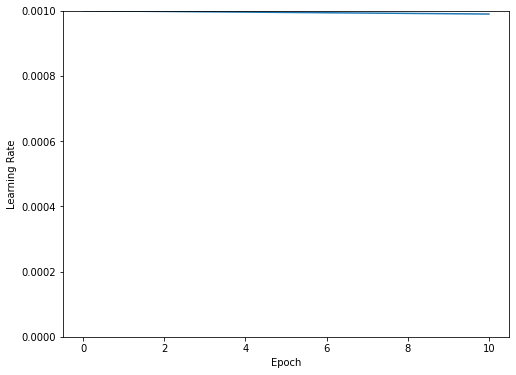

In [ ]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
# STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
STEPS_PER_EPOCH = 10000
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


def get_callbacks(name):
  checkpoint_filepath = '/content/dnn_model'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mean_absolute_error',
    mode='min',
    save_best_only=True)
  
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
    model_checkpoint_callback
  ]

In [ ]:
def read_data(file_path):
    # trainx is a 463715 × 90 matrix of training data, where each row is a 90-dimensional feature representation of a song.
    # trainy is a 463715 × 1 vector of labels associated with each training data. Each row is the release year of the corresponding song in trainx.
    # testx is a 51630 × 90 matrix of test data.
    
    mat = scipy.io.loadmat(file_path)
    train_x_data = mat['trainx']  # variable in mat file
    train_x_columns = [f'col_{num}' for num in range(len(train_x_data[0]))]
    train_x_rows = [f'index_{num}' for num in range(len(train_x_data))]
    train_x_df = pd.DataFrame(train_x_data, columns=train_x_columns, index=train_x_rows)
    train_y_data = mat['trainy']
    y_column = ['year']
    train_y_index = [f'index_{num}' for num in range(len(train_y_data))]
    train_y_df = pd.DataFrame(train_y_data, columns=y_column, index=train_y_index)
    test_x_data = mat['testx']  # variable in mat file
    test_x_columns = [f'col_{num}' for num in range(len(test_x_data[0]))]
    test_x_rows = [f'index_{num}' for num in range(len(test_x_data))]
    test_x_df = pd.DataFrame(test_x_data, columns=test_x_columns, index=test_x_rows)
    return train_x_df, train_y_df, test_x_df


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Year]')
  plt.legend()
  plt.grid(True)


In [ ]:
full_file_path = "/content/MSdata.mat"
train_x_df, train_y_df, test_x_df = read_data(full_file_path)
dataset = train_x_df.copy()
# dataset.tail()
# dataset.isna().sum()
max_year = train_y_df['year'].max()
min_year = train_y_df['year'].min()
y_input = train_y_df.year
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(train_x_df, y_input, test_size=0.1, random_state=42)


In [ ]:
# columns = ['col_' + str(i) for i in range(90)]
# print(columns)
# sns.pairplot(train_x_df[columns], diag_kind='kde')


In [ ]:
# sns.pairplot(train_x_df[['col_' + str(i) for i in range(90)]], diag_kind='kde')
# train_x_df.describe().transpose()
# x_train_split.describe().transpose()[['mean', 'std']]

In [ ]:
train_features = x_train_split.copy()
test_features = x_test_split.copy()
train_labels = y_train_split.copy()
test_labels = y_test_split.copy()


preprocessingNormalizer = preprocessing.Normalization()
preprocessingNormalizer.adapt(np.array(train_features))

batchNormalizer = layers.BatchNormalization()

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)


def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanAbsoluteError(),
                metrics=[
                  tf.keras.losses.MeanAbsoluteError(),
                  'accuracy'])

  model.summary()
  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
  
  history = model.fit(
    train_features, train_labels,
    validation_split=0.2,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    callbacks=get_callbacks(name),
    verbose=1)
  return history

FEATURES = 90
dnn_model = tf.keras.Sequential([
    preprocessingNormalizer,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu', input_shape=(FEATURES,)),
    batchNormalizer,
    layers.Dropout(0.2),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1)
])

In [ ]:
%%time
history = compile_and_fit(dnn_model, "dnn_model", optimizer=None, max_epochs=10000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 90)                181       
_________________________________________________________________
dense (Dense)                (None, 512)               46592     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

In [ ]:
dnn_model.load_weights("/content/dnn_model")
# plot_loss(history)
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=1)

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [Year]']).T

In [ ]:
import scipy.io
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, PolynomialFeatures
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


data_path = '/content/MSdata.mat'


# load data matrices, concatenate the data points with their labels, and return as one matrix
def read_data(file_path):
    mat = scipy.io.loadmat(file_path)
    X = mat['trainx']
    Y = mat['trainy']
    test = mat['testx']
    return X, Y, test


X, Y, test = read_data(data_path)
max_year = max(Y)
min_year = min(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)
Y_train = Y_train.ravel()
Y_test = Y_test.ravel()
Y = Y.ravel()

# SGD Regressor
# r = SGDRegressor(loss='epsilon_insensitive', epsilon=0.01, max_iter=10000, tol=1e-5, penalty='l1')

# Linear Ridge
# r = linear_model.Ridge(alpha=.5)

# Linear Lasso
# r = linear_model.Lasso(alpha=0.01)

# Linear Lasso LARS
# r = linear_model.LassoLars(alpha=.1)

# Bayesian Ridge
#r = linear_model.BayesianRidge()

# Logistic
# r = LogisticRegression(penalty='l2', random_state=42)

# Polynomial Degree 2
#r = PolynomialFeatures(degree=2)

# KNN Regressor
# r = KNeighborsRegressor(n_neighbors=2)

# MLP Regressor

r = MLPRegressor(random_state=1, max_iter=500)

reg = make_pipeline(StandardScaler(), r)

# for testing on the training data to determine MAE

# reg.fit_transform(X_train, Y_train)
reg.fit(X_train, Y_train)

pred = reg.predict(X_test)

pred[pred > max_year] = max_year
pred[pred < min_year] = min_year


MAE = mean_absolute_error(Y_test, pred)
print(MAE)


# print("Writing.......")
# file = open('result_stochasticgd.csv', 'w')
# file.write("dataid,prediction\n")
# for i in range(len(pred)):
#     file.write("{}, {} \n".format(i + 1, pred[i]))
# file.close()

